# Climate Change Belief Analysis

Sentiment analysis methods:
- Random Forest
- Naive Bayes
- k nearest neighbors
- Logistic Regression
- Linear SVC
- Transformer from Hugging Face (albert-base-v2-SST-2)

## 1. Import Libraries and Load Data

In [2]:
import os
import sys
import pickle

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import string
import random


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.cluster import KMeans

from sklearn import metrics
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import itertools
from collections import Counter
from wordcloud import WordCloud

from sklearn.utils import resample

sys.path.append('../src')  # Assuming 'process_data.py' is in the 'src' directory
from pre_process_data import pre_process_data

## 2. Data Preprocessing

In [5]:
# read training data
train_df = pd.read_csv('../data/train.csv')

r_train, r_train_X, r_train_y = pre_process_data(train_df, 'train')
r_train.head()

main_dir: C:\Users\tesal\Desktop\Teresa\code_projects\sentiment_analysis_twitter_climate_change


,message,tweetid,target,tokens,token_len,clean_message,is_authentic
2108,@Lawrence There is no climate change contribut...,9.385552e+17,2,"[contributing, severe, weather, pattern, dotar...",7,contributing severe weather pattern dotard sai...,1
12456,Russia hack deniers &amp; climate change denie...,7.952635e+17,2,"[russia, hack, denier, denier, lot, common, ei...",14,russia hack denier denier lot common either th...,1
11611,@NatlParkService @PadreIslandNPS Only a matter...,9.532696e+17,2,"[matter, time]",2,matter time,1
32801,Go on about how global warming is bullshite......,8.182981e+17,2,"[go, bullshite, clowncar]",3,go bullshite clowncar,1
15519,Who wants to place bets on @realDonaldTrump ca...,8.415544e+17,2,"[want, place, bet, calling, fake, tomorrow, mo...",8,want place bet calling fake tomorrow morning s...,1


## 3. Model Building

In [6]:
models = [RandomForestClassifier(max_depth = 15, n_estimators = 3000, random_state = 2),
          LinearSVC(),
          MultinomialNB(),
          LogisticRegression(random_state = 2, max_iter = 500),
          KMeans(n_clusters = 4, init = 'k-means++') ]

## 4. Train models

In [7]:
def train_models(mods, dataframe, X, y):
    df = dataframe.copy()
    for m in mods:
        # Train model
        m.fit(X,y)   

        # save models
        m_name = m.__class__.__name__
        with open(f'../models/{m_name}.pkl','wb') as f:
            pickle.dump(m,f)

        # save predictionson training set
        lab = 'pred_' + m_name
        df[lab] = m.predict(X)
    return df, mods

In [8]:
samp_preds, fitted_mods = train_models(models, r_train, r_train_X, r_train_y)

c:\Users\tesal\miniconda3\envs\climatenlp\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


## 5. Model Evaluation

In [9]:
##this method of checking models in parallel inspired by:
###https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
### by Susan Li --- "Multi-Class Text Classification with Scikit-Learn"

def model_performance(models_list, X, y):
    
    model_stats = pd.DataFrame(columns = ['Model','fold','score'])
  
    for model in models_list:
        model_name = model.__class__.__name__
        cross_val = cross_val_score(model, X, y, cv = 10, scoring = 'accuracy')
        for fol, acc in enumerate(cross_val):
            model_stats = model_stats.append({'Model':model_name, 'fold': fol, 'score': acc}, ignore_index = True)

            
        sns.boxplot(x = 'Model', y = 'score', data = model_stats)

        sns.stripplot(x = 'Model', y = 'score', data = model_stats, size = 8, edgecolor = 'gray', linewidth = 2)
    plt.show()

In [10]:
def get_model_stats(pred_frame, model_list, X, ret = False, pr = True):
    
    ##if we had a dumb alg to always guessm pro respone - the majority class
    pred_frame['pred_baseline'] = 2
    if pr:
        print('baseline - lazy algorithm that only picks class 2:\n')
    
    base_metrics =metrics.classification_report(pred_frame['target'], pred_frame['pred_baseline']
                                                , output_dict = True , zero_division = 0)
    bp_list = [[0,0,1,0] for i in range(pred_frame.shape[0])]
    baseline_prob = np.array(bp_list)
    bl_ll = log_loss(pred_frame['target'], baseline_prob)
    
    if pr:
        print(metrics.classification_report(pred_frame['target'], pred_frame['pred_baseline'], zero_division = 0))
        print('\n\n log_loss = ', bl_ll)
        print('\n\n #~~~~#~~~~#~~~~#~~~~#~~~~#~~~~# \n\n')      
    ##baseline generated, onto the models 
    
    reports = {'baseline' : base_metrics}
    ll_reports = {'baseline' : bl_ll}
    for model in model_list:
        l = 'pred_' + model.__class__.__name__
        mod_report = metrics.classification_report(pred_frame['target'], pred_frame[l], output_dict = True)
        
        if pr:
            print(l + ':\n')
            print(metrics.classification_report(pred_frame['target'], pred_frame[l]))
        
        reports[model.__class__.__name__] = mod_report
        try:
            m_ll = log_loss(pred_frame['target'], model.predict_proba(X))
            ll_reports[model.__class__.__name__] = m_ll
        except:
            ll_reports[model.__class__.__name__] = np.nan
            
            
        if pr:
            try:   
                print('\n\n log_loss = ', m_ll)
                
            except:
                print('\n\n log_loss = Model does not produce proba')

            print('\n\n #~~~~#~~~~#~~~~#~~~~#~~~~#~~~~# \n\n')
            
            
    
    if ret:
        return reports, ll_reports

In [11]:
get_model_stats(samp_preds, fitted_mods, r_train_X )

baseline - lazy algorithm that only picks class 2:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.25      1.00      0.40     10000
           3       0.00      0.00      0.00     10000

    accuracy                           0.25     40000
   macro avg       0.06      0.25      0.10     40000
weighted avg       0.06      0.25      0.10     40000



 log_loss =  27.032740041837858


 #~~~~#~~~~#~~~~#~~~~#~~~~#~~~~# 


pred_RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.73      0.52      0.61     10000
           1       0.40      0.71      0.51     10000
           2       0.69      0.32      0.44     10000
           3       0.60      0.63      0.62     10000

    accuracy                           0.55     40000
   macro avg       0.60      0.55      0.54     40000
weighted avg       0.60      0.

c:\Users\tesal\miniconda3\envs\climatenlp\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(




 log_loss =  1.2408515744008644


 #~~~~#~~~~#~~~~#~~~~#~~~~#~~~~# 


pred_LinearSVC:

              precision    recall  f1-score   support

           0       0.75      0.77      0.76     10000
           1       0.65      0.64      0.65     10000
           2       0.68      0.62      0.65     10000
           3       0.74      0.81      0.77     10000

    accuracy                           0.71     40000
   macro avg       0.71      0.71      0.71     40000
weighted avg       0.71      0.71      0.71     40000



 log_loss =  1.2408515744008644


 #~~~~#~~~~#~~~~#~~~~#~~~~#~~~~# 


pred_MultinomialNB:

              precision    recall  f1-score   support

           0       0.70      0.77      0.73     10000
           1       0.63      0.57      0.60     10000
           2       0.63      0.55      0.59     10000
           3       0.71      0.80      0.75     10000

    accuracy                           0.67     40000
   macro avg       0.67      0.67      0.67     40000
wei

In [12]:
# Confusion Matrix
def am_confus(mod_ls, y_actu, y_pred):
    matrix = confusion_matrix(y_actu, y_pred)
    plt.figure(figsize = (10,8))
    sns.heatmap(matrix, annot =True, xticklabels = [0,1,2,3], yticklabels = [0,1,2,3], fmt = 'g')
    plt.title(mod_ls)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()


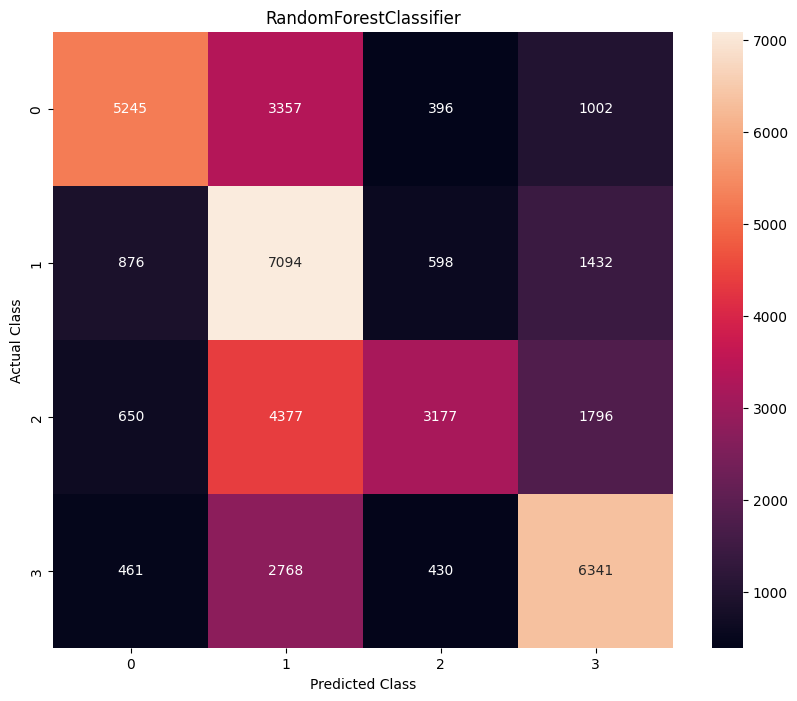

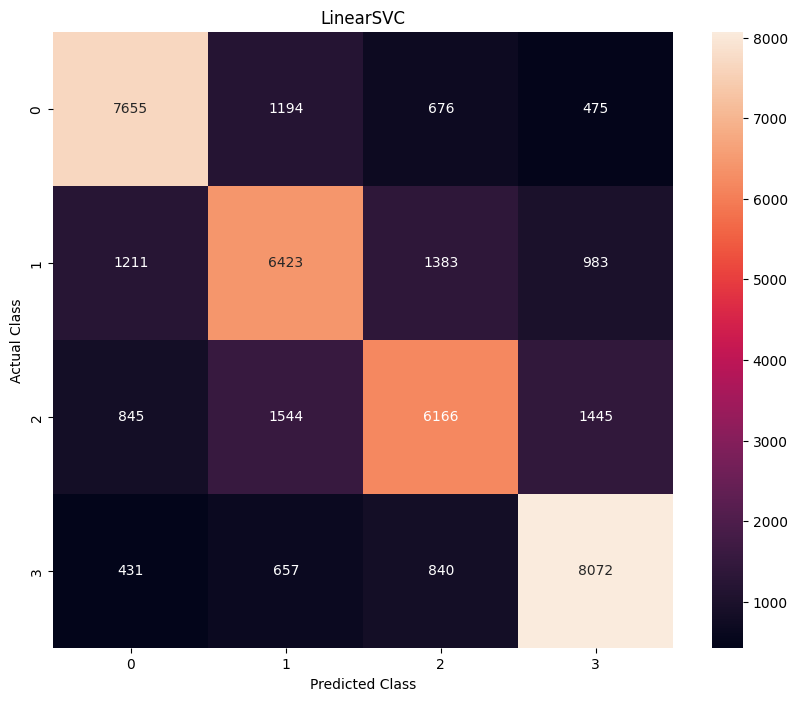

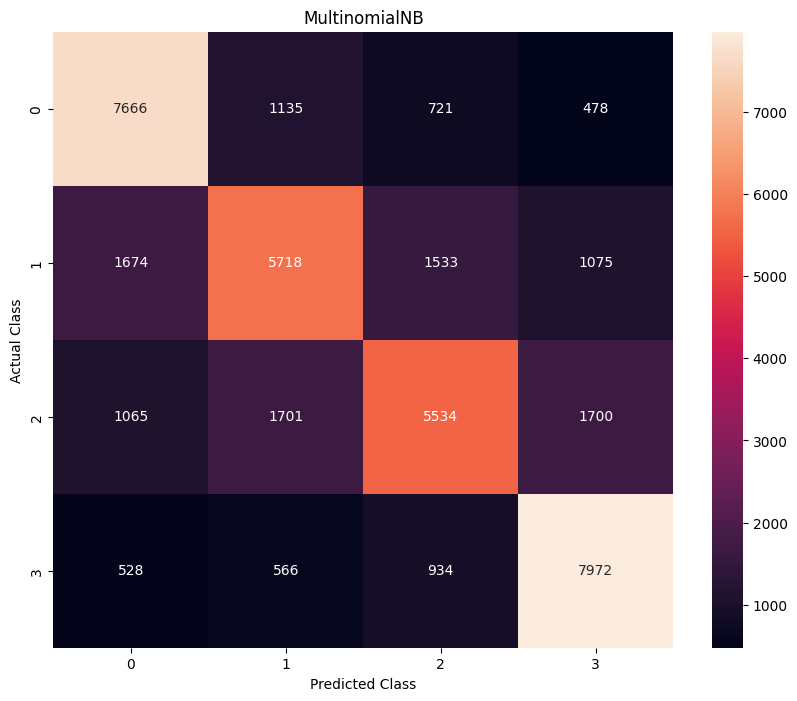

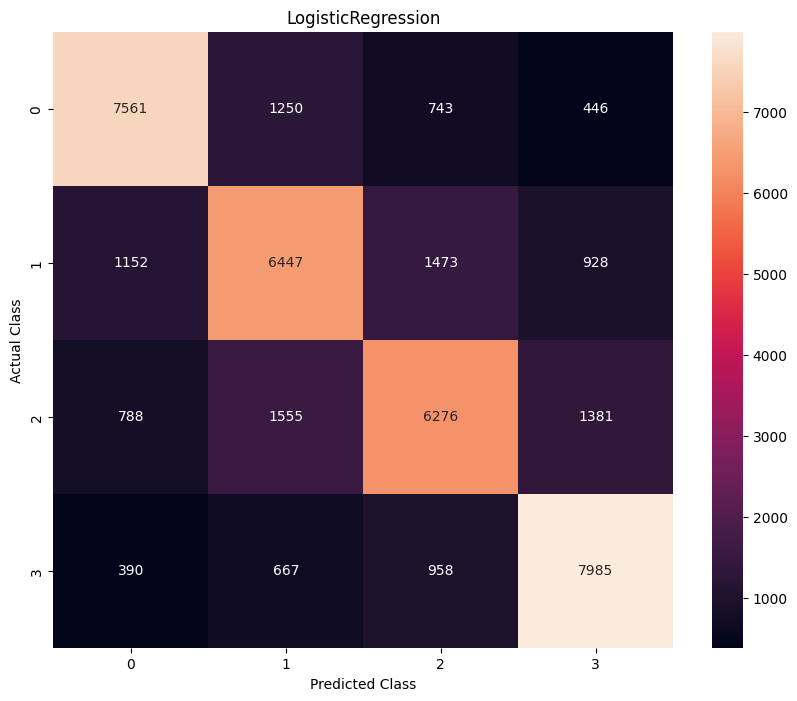

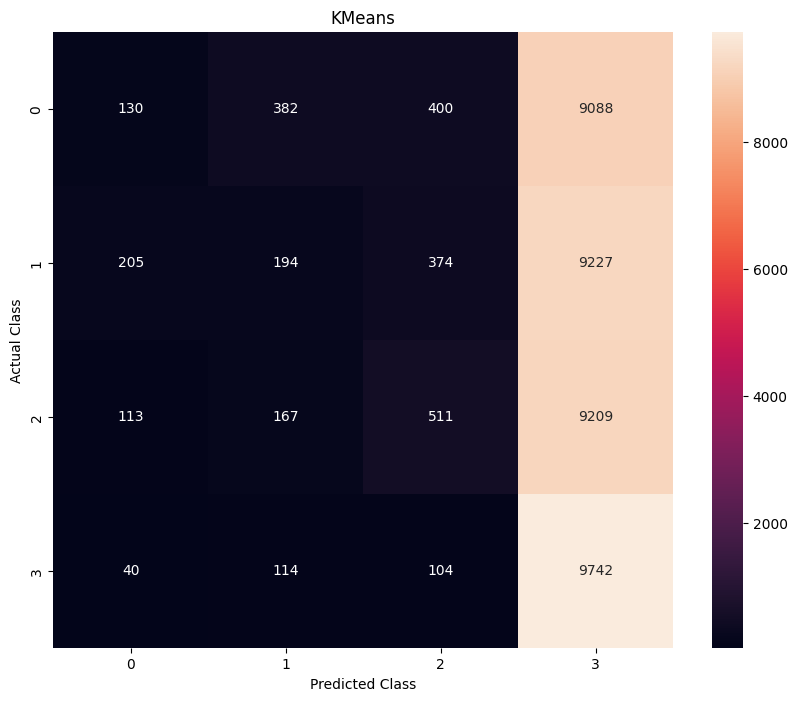

In [13]:
for m in models:
    name = m.__class__.__name__
    lab = 'pred_' + name
    am_confus(name, samp_preds['target'], samp_preds[lab]) 